# 03 — Correlation Analysis

**Goal:** Quantify the relationship between the **House Price Index (HPI)** and key drivers.

We compute **Pearson** and **Spearman** correlations between:
- HPI and **net earnings** (levels)
- HPI and **real net earnings** (levels; deflated by HICP)
- **HPI growth** and **GDP growth**
- **HPI growth** and **inflation** (HICP YoY %)
- HPI and **unemployment** (levels)

We compare **Bulgaria** to **EU averages**, and make **scatter plots with regression lines** (pooled EU27).
Data source: `data/processed/merged_panel.csv` (from `01_data_preparation.ipynb`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import Dict, List, Tuple

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

PROC = Path("../data/processed")
FIGS = Path("../reports/figures")

PROC, FIGS

EU27 = {
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia","Finland",
    "France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg",
    "Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"
}

## 1) Load panel & create growth rates

We compute **YoY %** growth by country:
- `hpi_growth_pct`, `gdp_growth_pct`, `inflation_pct` (= HICP YoY %), and `earnings_growth_pct`.


In [2]:
panel = pd.read_csv(PROC / "merged_panel.csv").sort_values(["country","year"]).reset_index(drop=True)

panel_g = panel.copy()
for col in ["house_price_index", "gdp_per_capita", "hicp_index", "net_earnings", "real_earnings"]:
    panel_g[col + "_growth_pct"] = panel_g.groupby("country")[col].pct_change() * 100

cols = [
    "country","year",
    "house_price_index","net_earnings","real_earnings","unemployment_rate","gdp_per_capita","hicp_index",
    "house_price_index_growth_pct","gdp_per_capita_growth_pct","hicp_index_growth_pct","net_earnings_growth_pct","real_earnings_growth_pct"
]
panel_g = panel_g[cols]
panel_g.head(20)


,country,year,house_price_index,net_earnings,real_earnings,unemployment_rate,gdp_per_capita,hicp_index,house_price_index_growth_pct,gdp_per_capita_growth_pct,hicp_index_growth_pct,net_earnings_growth_pct,real_earnings_growth_pct
0,Austria,2015,128.63,34414.48,34414.480000,6.1,39640.0,100.00,NaN,NaN,NaN,NaN,NaN
1,Austria,2016,136.27,36707.82,36355.174804,6.5,40690.0,100.97,5.939516,2.648840,0.970000,6.663881,5.639181
2,Austria,2017,144.48,37220.14,36059.038946,5.9,41760.0,103.22,6.024804,2.629639,2.228385,1.395670,-0.814563
3,Austria,2018,153.57,37847.53,35905.065933,5.2,43360.0,105.41,6.291528,3.831418,2.121682,1.685620,-0.427003
4,Austria,2019,162.82,41162.12,38476.462890,4.8,44570.0,106.98,6.023312,2.790590,1.489422,8.757745,7.161655
5,Austria,2020,175.30,42589.37,39263.731907,6.0,42650.0,108.47,7.664906,-4.307830,1.392784,3.467387,2.046105
6,Austria,2021,198.25,42549.21,38174.421317,6.2,45380.0,111.46,13.091843,6.400938,2.756523,-0.094296,-2.774343
7,Austria,2022,221.28,47272.61,39045.684315,4.8,49490.0,121.07,11.616646,9.056853,8.621927,11.101029,2.282321
8,Austria,2023,212.27,48897.51,37498.090491,5.1,51830.0,130.40,-4.071764,4.728228,7.706286,3.437297,-3.963546
9,Austria,2024,208.89,52978.41,39474.264213,5.2,52760.0,134.21,-1.592312,1.794328,2.921779,8.345824,5.270065


## 2) Helper functions

- `corr_pair(df, x, y)` → Pearson & Spearman between two columns
- `per_country_corr(df, x, y)` → per-country correlations (+N)


In [3]:
def corr_pair(df: pd.DataFrame, x: str, y: str) -> Dict[str, float]:
    """
    Compute Pearson and Spearman correlations between two columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input frame containing the columns `x` and `y`.
    x : str
        Column name for the first variable.
    y : str
        Column name for the second variable.

    Returns
    -------
    Dict[str, float]
        A dictionary with keys:
        - "pearson": Pearson correlation (NaN if < 3 rows after dropping NA).
        - "spearman": Spearman correlation (NaN if < 3 rows after dropping NA).
        - "N": number of non-missing observations used (as float for easy CSV export).

    Notes
    -----
    - Rows with NA in either column are dropped.
    - Requires at least 3 observations to compute both statistics.
    """
    d = df[[x, y]].dropna()
    if d.shape[0] < 3:
        return {"pearson": float("nan"), "spearman": float("nan"), "N": float(d.shape[0])}
    return {
        "pearson": float(d[x].corr(d[y], method="pearson")),
        "spearman": float(d[x].corr(d[y], method="spearman")),
        "N": float(d.shape[0]),
    }


def per_country_corr(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    """
    Compute per-country Pearson and Spearman correlations between two columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input frame; must contain columns: 'country', `x`, `y`.
    x : str
        Column name for the first variable.
    y : str
        Column name for the second variable.

    Returns
    -------
    pd.DataFrame
        One row per country with columns:
        - country : str
        - pearson : float
        - spearman : float
        - N : int  (observations used per country)

    Notes
    -----
    - Drops rows with NA in either `x` or `y` within each country.
    - Countries with fewer than 3 observations are excluded.
    """
    rows: List[Dict[str, float]] = []
    for c, g in df.groupby("country", dropna=False):
        d = g[[x, y]].dropna()
        if d.shape[0] >= 3:
            rows.append({
                "country": c,
                "pearson": float(d[x].corr(d[y], method="pearson")),
                "spearman": float(d[x].corr(d[y], method="spearman")),
                "N": int(d.shape[0]),
            })
    return pd.DataFrame(rows).sort_values("country").reset_index(drop=True)


## 3) Pooled EU27 correlations (all countries × years pooled)

We compute correlations on EU27 rows only (to avoid non-EU outliers).
Pairs:
- **Levels:** HPI ~ net earnings, HPI ~ real earnings, HPI ~ unemployment
- **Growths:** HPI YoY % ~ GDP YoY %, HPI YoY % ~ Inflation YoY % (HICP)


In [4]:
eu = panel_g[panel_g["country"].isin(EU27)].copy()

pairs = {
    "HPI vs Net earnings (levels)": ("house_price_index", "net_earnings"),
    "HPI vs Real earnings (levels)": ("house_price_index", "real_earnings"),
    "HPI vs Unemployment (levels)": ("house_price_index", "unemployment_rate"),
    "HPI growth vs GDP growth": ("house_price_index_growth_pct", "gdp_per_capita_growth_pct"),
    "HPI growth vs Inflation (HICP YoY %)": ("house_price_index_growth_pct", "hicp_index_growth_pct"),
}

pooled = []
for name, (x, y) in pairs.items():
    r = corr_pair(eu, x, y)
    pooled.append({"pair": name, **r})

pooled_corr = pd.DataFrame(pooled)
pooled_corr


,pair,pearson,spearman,N
0,HPI vs Net earnings (levels),0.101448,0.138453,258.0
1,HPI vs Real earnings (levels),-0.016933,0.032456,258.0
2,HPI vs Unemployment (levels),-0.475255,-0.544212,258.0
3,HPI growth vs GDP growth,0.417307,0.415170,232.0
4,HPI growth vs Inflation (HICP YoY %),0.279501,0.201042,232.0


## 4) Per-country correlations (EU27)

We compute Pearson & Spearman **per country** for the same pairs.  
Then we compare **Bulgaria** vs the **EU average** (mean and median across countries).


In [5]:
def per_country_block(df: pd.DataFrame, x: str, y: str, label: str) -> pd.DataFrame:
    """
    Wrap `per_country_corr` and rename outputs with a label prefix.

    Parameters
    ----------
    df : pd.DataFrame
        Input frame containing 'country', `x`, and `y`.
    x : str
        First variable name.
    y : str
        Second variable name.
    label : str
        Prefix for output columns (e.g., "hpi_vs_net").

    Returns
    -------
    pd.DataFrame
        Columns:
        - country : str
        - {label}_pearson : float
        - {label}_spearman : float
        - N : int
    """
    out = per_country_corr(df, x, y)
    out = out.rename(columns={
        "pearson": f"{label}_pearson",
        "spearman": f"{label}_spearman",
        "N": f"{label}_N",
    })
    return out[["country", f"{label}_pearson", f"{label}_spearman", f"{label}_N"]]

blocks = []
blocks.append(per_country_block(eu, "house_price_index", "net_earnings", "hpi_vs_net"))
blocks.append(per_country_block(eu, "house_price_index", "real_earnings", "hpi_vs_real"))
blocks.append(per_country_block(eu, "house_price_index", "unemployment_rate", "hpi_vs_unemp"))
blocks.append(per_country_block(eu, "house_price_index_growth_pct", "gdp_per_capita_growth_pct", "hpi_g_vs_gdp_g"))
blocks.append(per_country_block(eu, "house_price_index_growth_pct", "hicp_index_growth_pct", "hpi_g_vs_infl_g"))

from functools import reduce
# per_geo = reduce(lambda L, R: pd.merge(L, R, on=["country","N"], how="outer"), blocks)
per_geo = reduce(lambda L, R: pd.merge(L, R, on="country", how="outer"), blocks)
per_geo = per_geo.sort_values("country").reset_index(drop=True)
per_geo.head(10)


,country,hpi_vs_net_pearson,hpi_vs_net_spearman,hpi_vs_net_N,hpi_vs_real_pearson,hpi_vs_real_spearman,hpi_vs_real_N,hpi_vs_unemp_pearson,hpi_vs_unemp_spearman,hpi_vs_unemp_N,hpi_g_vs_gdp_g_pearson,hpi_g_vs_gdp_g_spearman,hpi_g_vs_gdp_g_N,hpi_g_vs_infl_g_pearson,hpi_g_vs_infl_g_spearman,hpi_g_vs_infl_g_N
0,Austria,0.922084,0.939394,10,0.780803,0.721212,10,-0.544803,-0.585377,10,0.241642,0.333333,9,-0.151549,0.016667,9
1,Belgium,0.969365,1.000000,10,0.338652,0.418182,10,-0.750246,-0.759882,10,0.520628,0.416667,9,0.396710,0.166667,9
2,Bulgaria,0.995329,1.000000,10,0.968418,1.000000,10,-0.835489,-0.957335,10,0.578875,0.400000,9,0.605834,0.450000,9
3,Croatia,0.995074,1.000000,10,0.917376,0.963636,10,-0.774271,-0.915152,10,0.393388,0.583333,9,0.841987,0.750000,9
4,Cyprus,0.991551,0.976190,8,0.838236,0.690476,8,-0.849677,-0.958101,8,0.329141,0.071429,7,0.740754,0.750000,7
5,Czechia,0.976928,0.951515,10,0.668900,0.672727,10,-0.567464,-0.541603,10,0.410729,0.500000,9,-0.021964,0.166667,9
6,Denmark,0.919569,0.951515,10,0.218034,0.418182,10,-0.502443,-0.521512,10,0.773457,0.683333,9,-0.085858,0.116667,9
7,Estonia,0.953948,1.000000,10,0.059048,0.369697,10,0.301584,0.200609,10,0.800450,0.766667,9,0.737297,0.400000,9
8,Finland,0.078758,0.115152,10,0.640599,0.842424,10,-0.533885,-0.579279,10,0.302453,0.200000,9,-0.293687,-0.366667,9
9,France,0.849575,0.927273,10,-0.818011,-0.769697,10,-0.956699,-0.996965,10,-0.037284,0.133333,9,-0.027285,-0.083333,9


In [6]:
def summarize_country(df: pd.DataFrame, country: str = "Bulgaria") -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Extract the row for a given country and compute EU mean/median across countries.

    Parameters
    ----------
    df : pd.DataFrame
        Per-country correlation table (must include 'country' and 'N' plus metric columns).
    country : str, default "Bulgaria"
        Country to extract for comparison.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        - row : 1xK DataFrame for the selected country
        - eu_mean : 1xK DataFrame (mean across countries for numeric columns)
        - eu_median : 1xK DataFrame (median across countries for numeric columns)

    Notes
    -----
    - Non-numeric columns ('country', 'N') are excluded from mean/median.
    """
    row = df[df["country"] == country]

    if row.empty:
        print(f"WARNING: '{country}' not found in table.")

    num_cols = df.select_dtypes(include="number").columns

    exclude = { "N" } | {c for c in num_cols if c.endswith("_N")}
    metric_cols = [c for c in num_cols if c not in exclude]

    eu_mean = df[metric_cols].mean().to_frame("EU_mean").T
    eu_median = df[metric_cols].median().to_frame("EU_median").T
    return row, eu_mean, eu_median

bg_row, eu_mean, eu_median = summarize_country(per_geo, "Bulgaria")
bg_row, eu_mean, eu_median

(    country  hpi_vs_net_pearson  hpi_vs_net_spearman  hpi_vs_net_N  \
 2  Bulgaria            0.995329                  1.0            10   
 
    hpi_vs_real_pearson  hpi_vs_real_spearman  hpi_vs_real_N  \
 2             0.968418                   1.0             10   
 
    hpi_vs_unemp_pearson  hpi_vs_unemp_spearman  hpi_vs_unemp_N  \
 2             -0.835489              -0.957335              10   
 
    hpi_g_vs_gdp_g_pearson  hpi_g_vs_gdp_g_spearman  hpi_g_vs_gdp_g_N  \
 2                0.578875                      0.4                 9   
 
    hpi_g_vs_infl_g_pearson  hpi_g_vs_infl_g_spearman  hpi_g_vs_infl_g_N  
 2                 0.605834                      0.45                  9  ,
          hpi_vs_net_pearson  hpi_vs_net_spearman  hpi_vs_real_pearson  \
 EU_mean            0.901879             0.915634             0.484896   
 
          hpi_vs_real_spearman  hpi_vs_unemp_pearson  hpi_vs_unemp_spearman  \
 EU_mean              0.538212             -0.630827          

## 5) Visualizations — pooled EU27 scatters with regression lines

We draw simple OLS lines via `numpy.polyfit`.  
- **Levels:** HPI vs Net earnings, HPI vs Real earnings, HPI vs Unemployment  
- **Growths:** HPI YoY % vs GDP YoY %, HPI YoY % vs HICP YoY %


In [7]:
def scatter_with_line(
    df: pd.DataFrame,
    x: str,
    y: str,
    title: str,
    xlabel: str,
    ylabel: str,
    outname: str,
) -> None:
    """
    Draw a scatter plot with a simple OLS best-fit line (via numpy.polyfit).

    Parameters
    ----------
    df : pd.DataFrame
        Input frame containing columns `x` and `y`.
    x : str
        X-axis variable name.
    y : str
        Y-axis variable name.
    title : str
        Plot title.
    xlabel : str
        X-axis label.
    ylabel : str
        Y-axis label.
    outname : str
        File name (PNG) to save under `reports/figures/`.

    Returns
    -------
    None
        Saves the figure and displays it.

    Notes
    -----
    - Rows with NA in `x` or `y` are dropped.
    - If fewer than 2 valid points remain, only the scatter is drawn (no line).
    """
    d = df[[x, y]].dropna()
    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    ax.scatter(d[x], d[y], alpha=0.35)

    if len(d) >= 2:
        X = d[x].to_numpy()
        Y = d[y].to_numpy()
        mask = np.isfinite(X) & np.isfinite(Y)
        if mask.sum() >= 2:
            b1, b0 = np.polyfit(X[mask], Y[mask], 1)
            xs = np.linspace(X[mask].min(), X[mask].max(), 100)
            ax.plot(xs, b0 + b1 * xs, linewidth=2, label=f"OLS slope = {b1:.3g}")
            ax.legend()

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    ax.tick_params(labelsize=11)
    plt.tight_layout()
    plt.savefig(FIGS / outname, dpi=160)
    plt.show()


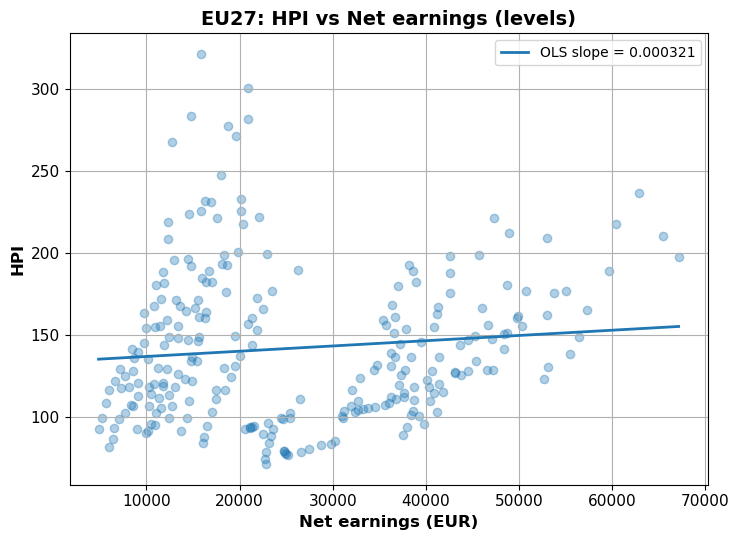

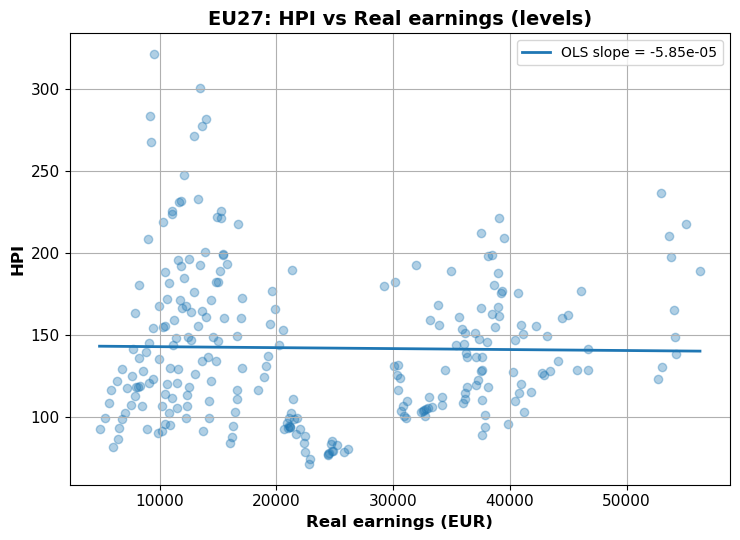

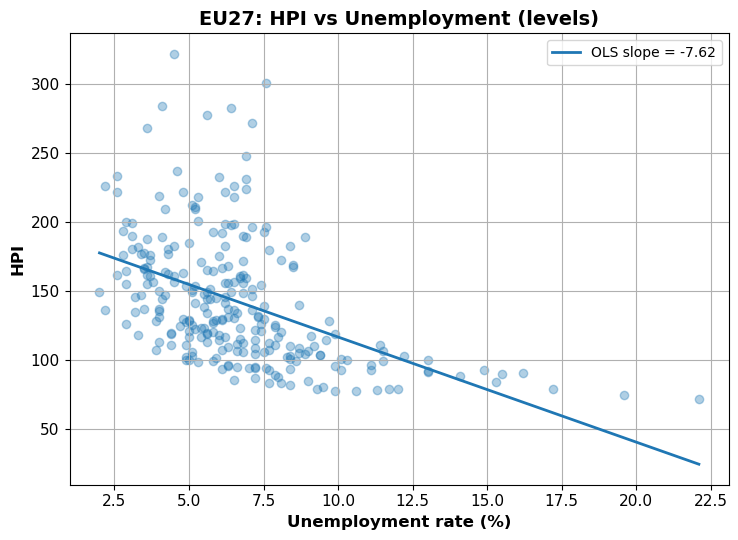

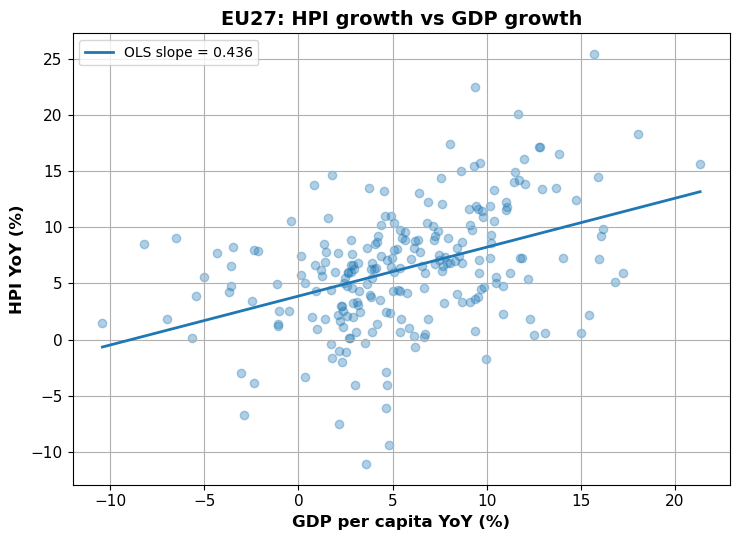

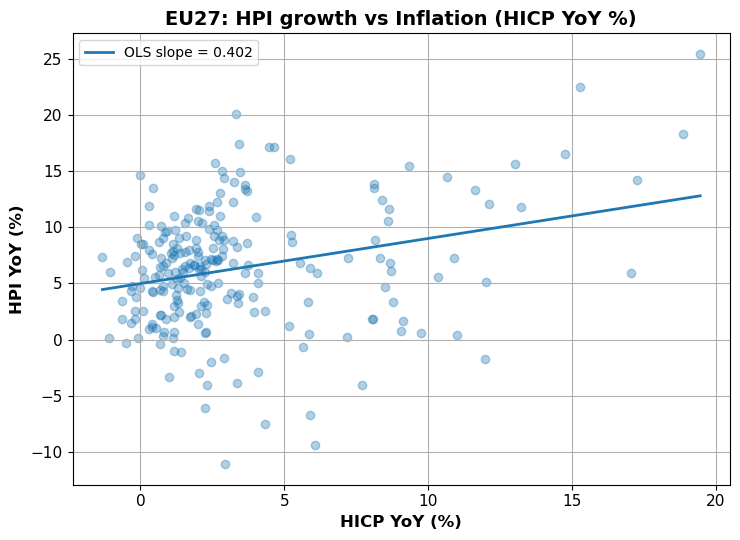

In [8]:
scatter_with_line(eu, "net_earnings", "house_price_index",
                  "EU27: HPI vs Net earnings (levels)",
                  "Net earnings (EUR)", "HPI", "eu_scatter_hpi_vs_net.png")

scatter_with_line(eu, "real_earnings", "house_price_index",
                  "EU27: HPI vs Real earnings (levels)",
                  "Real earnings (EUR)", "HPI", "eu_scatter_hpi_vs_real.png")

scatter_with_line(eu, "unemployment_rate", "house_price_index",
                  "EU27: HPI vs Unemployment (levels)",
                  "Unemployment rate (%)", "HPI", "eu_scatter_hpi_vs_unemp.png")

scatter_with_line(eu, "gdp_per_capita_growth_pct", "house_price_index_growth_pct",
                  "EU27: HPI growth vs GDP growth",
                  "GDP per capita YoY (%)", "HPI YoY (%)", "eu_scatter_hpi_g_vs_gdp_g.png")

scatter_with_line(eu, "hicp_index_growth_pct", "house_price_index_growth_pct",
                  "EU27: HPI growth vs Inflation (HICP YoY %)",
                  "HICP YoY (%)", "HPI YoY (%)", "eu_scatter_hpi_g_vs_infl_g.png")


## 6) Bulgaria-only scatter checks

Quick visual sanity check for Bulgaria’s relationship in levels & growths.


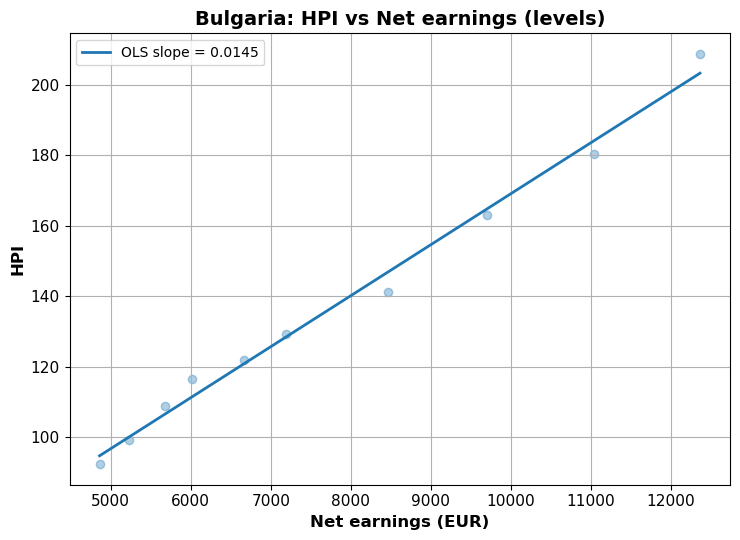

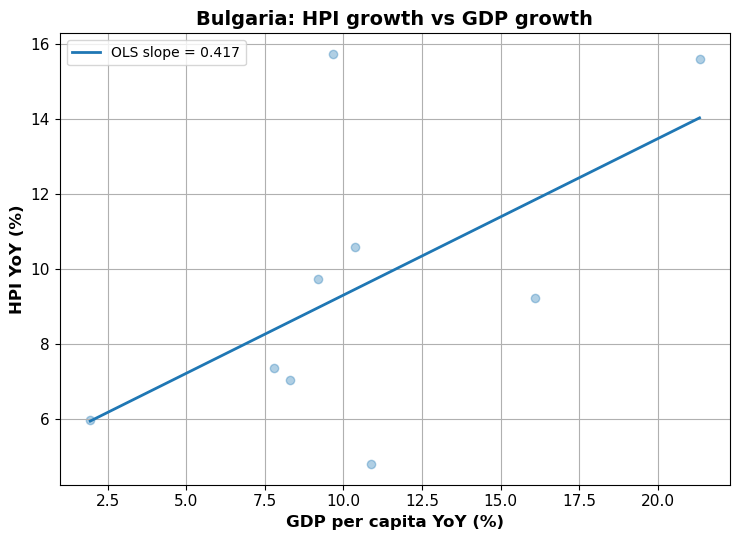

In [9]:
bg = panel_g[panel_g["country"] == "Bulgaria"].copy()

scatter_with_line(bg, "net_earnings", "house_price_index",
                  "Bulgaria: HPI vs Net earnings (levels)",
                  "Net earnings (EUR)", "HPI", "bg_scatter_hpi_vs_net.png")

scatter_with_line(bg, "gdp_per_capita_growth_pct", "house_price_index_growth_pct",
                  "Bulgaria: HPI growth vs GDP growth",
                  "GDP per capita YoY (%)", "HPI YoY (%)", "bg_scatter_hpi_g_vs_gdp_g.png")


## 7) Save correlation tables

We export: (a) pooled EU correlations, (b) per-country correlations (EU27), and a small **Bulgaria vs EU** summary.


In [10]:
pooled_path = PROC / "corr_pooled_eu27.csv"
per_geo_path = PROC / "corr_per_country_eu27.csv"
summary_path = PROC / "corr_summary_bg_vs_eu27.csv"

pooled_corr.to_csv(pooled_path, index=False)
per_geo.to_csv(per_geo_path, index=False)

bg_summary = pd.concat([bg_row.set_index("country"), eu_mean, eu_median], axis=0)
bg_summary.to_csv(summary_path)
pooled_path, per_geo_path, summary_path


(WindowsPath('../data/processed/corr_pooled_eu27.csv'),
 WindowsPath('../data/processed/corr_per_country_eu27.csv'),
 WindowsPath('../data/processed/corr_summary_bg_vs_eu27.csv'))

# Correlation Analysis — Notes for the report

### Europe-wide findings
- **HPI vs Net earnings (levels):** Very weak correlation (Pearson ≈ 0.10, Spearman ≈ 0.14).  
- **HPI vs Real earnings (levels):** Essentially no correlation (Pearson ≈ 0.0). Supports the idea of affordability decoupling.  
- **HPI vs Unemployment:** Moderate negative correlation (Pearson ≈ -0.48, Spearman ≈ -0.54). Higher unemployment → lower HPI.  
- **HPI growth vs GDP growth:** Moderate positive correlation (Pearson ≈ 0.42). Stronger GDP growth often comes with rising HPI.  
- **HPI growth vs Inflation:** Weak but positive correlation (Pearson ≈ 0.28).  

**Takeaway EU:** HPI correlates more with macro fundamentals (GDP, unemployment, inflation) than with earnings. Real earnings do not explain house price growth at the European level.

---

### Bulgaria compared to EU
- **HPI vs Net earnings:** Extremely strong correlation (Pearson ≈ 0.995, Spearman = 1.0) → much tighter than EU mean (≈0.90).  
- **HPI vs Real earnings:** Strong correlation (Pearson ≈ 0.97, Spearman = 1.0), while EU average is weak (~0.48).  
- **HPI vs Unemployment:** Very strong negative correlation (Pearson ≈ -0.84, Spearman ≈ -0.96), tighter than EU average (-0.63).  
- **HPI growth vs GDP growth:** Moderately strong (Pearson ≈ 0.58) vs EU mean (≈0.34).  
- **HPI growth vs Inflation:** Moderate–strong (Pearson ≈ 0.61) vs EU mean (≈0.22).  

**Takeaway Bulgaria:** Unlike EU, Bulgaria’s housing market is **tightly coupled** to wages and macroeconomic variables. No decoupling: affordability and fundamentals still drive housing prices.

---

### Scatter plot insights
- **EU plots:** Clouds of points, weak slopes for earnings; unemployment shows a clear negative slope; GDP/inflation show noisy but positive slopes.  
- **Bulgaria plots:** Very clean, steep slopes — HPI tracks wages and GDP almost mechanically, and is strongly inverse to unemployment.

---

### Saved figures
- `reports/figures/eu_scatter_hpi_vs_net.png`
- `reports/figures/eu_scatter_hpi_vs_real.png`
- `reports/figures/eu_scatter_hpi_vs_unemp.png`
- `reports/figures/eu_scatter_hpi_g_vs_gdp_g.png`
- `reports/figures/eu_scatter_hpi_g_vs_infl_g.png`
- `reports/figures/bg_scatter_hpi_vs_net.png`
- `reports/figures/bg_scatter_hpi_g_vs_gdp_g.png`
